# Start Here 

This notebook contains structured, annotated code that when run through in entirety recreates the analysis done for the paper. The preprocessing section takes the raw data into a format ready for analysis. The main experiment analysis and saline experiment analysis perform statistics and generate plots for the main experiment and the control saline experiment respectively. 

Most of the code relies on the experimental parameters in the experiment_config.json. One can change parameters there and then re-run to see the effect of changing different parameters of the study (such as number of permutations, frequency range for alpha band, etc.). Additionally, a lot of the code is packaged into functions in either the data_processing.py, statistics.py, or plotting.py which is then imported here to run.

Note that a lot of the code is quite memory and computationally intensive. It was written for and run on a machine with 64GB of memory, up to 24 available cores for parallel computation, and 1 TB of disk space. As such, one needs a fair amount of space and computing resources for some of the steps (and you will need to adjust the number of parallel threads accordingly).

It is recommended that you use this notebook with the table of contents notebook extension as one can then interactively navigate through different sections.

# Preprocessing

This section takes the data from the original blackrock data format to a compressed numpy array containing a time-frequency power representation. Be sure to first run the the cell below to create the data folder hierarchy. One can try to re-create the full process from the original blackrock data, but this requires manually extracting the stimulation onsets and offsets and data from the blackrock format. Alternatively, the preprocessing is fully automated from the Generate Stimulation Onset & Offset Locked Epochs section on. 

In [ ]:
import os
if not os.exists('../data/raw/original_raw'):
    os.makedirs('../data/raw/original_raw')
if not os.exists('../data/raw/manual_events'):
    os.makedirs('../data/raw/manual_events')
if not os.exists('../data/raw/matlab_extracted'):
    os.makedirs('../data/raw/matlab_extracted')
if not os.exists('../data/power'):
    os.makedirs('../data/power')
if not os.exists('../data/epochs'):
    os.makedirs('../data/epochs')

## Extract .mat Files from the Blackrock Raw Files

** Blackrock Data Files **

Blackrock raw data files come in their own format: http://support.blackrockmicro.com/KB/View/166838-file-specifications-packet-details-headers-etc

Luckily, we don't need too much knowledge of the inner workings of their data formats for two reasons:

1. All of the recorded neural data live in the .ns2 suffixed files in the raw > blackrock_original_data folder. These files house all of the actual electrode recordings from the implanted arrays. The other files we are interested in are the .ns5 files. These files contain an analog input channel that holds a copy of the feedback stimulation waveform. We will also extract this input in order to compare it with our controlling electrode to see how successfully we suppressed artifact from the stimulation. See the above link for descriptions of what the other files in this folder contain. 
2. Blackrock has a toolkit <a href="http://support.blackrockmicro.com/KB/View/166898-matlab-interfacing-and-analysis">NPMK</a> for extracting data from their file formats into MATLAB structs. I used this toolkit to extract the data as detailed below.

** Extracting the Data with NPMK **

1. First, I downloaded the NPMK (v. 4.4.0.0) toolkit folder via the instructions in the link above.
2. Then I executed the following two lines in the MATLAB command line so that matlab will find the NPMK functions ($software should be replaced with the path to where you downloaded the toolkit):

        addpath '$software/NPMK-4.4.0.0/NPMK/'
 addpath '$software/NPMK-4.4.0.0/NPMK/Dependent Functions'
        
3. Type 'openNSx' at the command prompt. Then select the desired .ns2 or .ns5 file from data/raw/blackrock_original_data and click open via the gui that pops up.
4. Save the resulting matlab struct with the following command where DATE gets replaced with the date in the filename (or saline for the saline test), 'NS2' or 'NS5' is the name of the extracted struct object, and '-v7.3' uses a version of save that supports larger file sizes (this assumes matlab's current directory is the project's base directory):

        save('data/raw/matlab_extracted_data/DATE_ns(2|5).mat', 'NS(2|5)', '-v7.3')

5. Repeat separately for each date's .ns2 and .ns5 file.

## Create Raw FIF files from Extracted .mat Files 

Unfortunately, Fieldtrip's functions for converting blackrock data into fieldtrip format are not fully functional. Because of this, I decided to just manually construct a raw object from the .mat file with MNE since I have a better understanding of the inner workings of MNE raw objects.

To do so I scrape out the bare minimum information needed to make an analyzable raw object:
  - The names of the channels.
  - The sampling rate.
  - The actual data.
  - The digital to analog scaling factor.

I store the data as 'EEG' channels because MNE does not have explicit representations for intracranial recordings. Note that the data needs to be scaled appropriately to convert from digitized units to microvolts. Additionally, I add an extra STIM channel with all 0's to be used to designate the stimulation events extracted in the next step.

In [4]:
import numpy as np
from mne import create_info
from mne.io import RawArray
import glob
import re
from data_processing import extract_blackrock_info, create_mne_raw
import h5py

%reset -f

# iterate through raw data files
fnames = sorted(glob.glob('../data/raw/matlab_extracted_data/*ns*.mat'))
for f in fnames:
    
    # extract date and recording type info from file name
    search = re.search('(\d{7}|saline\d).*(ns2|ns5)', f)
    typ, date = search.group(2), search.group(1)
    if 'saline1' not in date : continue
    print('Creating Raw %s fif File for Date: %s' %(typ, date))
    
    # extract blackrock recording info and data
    blackrock_info = extract_blackrock_info(f, typ)
    
    # create the MNE raw object
    raw = create_mne_raw(blackrock_info)
    
    # save out to file
    raw.save('../data/raw/original_raw/%s_%s_raw.fif' %(date, typ), 
             verbose=False, overwrite=True)

print('Done!')

Creating Raw ns2 fif File for Date: saline1
Done!


## Manually Extract Stimulation Period Events 

Unfortunately, all of the timing of stimulation was done manually (meaning it isn't very precise) and none of the stimulation onsets & offsets were recorded in stim channels. Consequently, these stimulation events need to be extracted from the data. I tried playing around with some automatic extraction techniques, but overall found manual extraction to be more reliable.

Thus, I manually extracted events as follows:

1. Load the data in mne_browse_raw (File > Open)
2. Load the corresponding channel selections file so the data is visible (File > Load Channel Selections). Select either the .ns2 or the .ns5 file accordingly.
3. Set the viewing scale to be large (Adjust > Scales > EEG = 5e6) so the stimulation periods stand out. 
4. Turn off the average reference projection (Adjust > Projection > All On/Off).
3. Go through and manually mark both the onset and offset of stimulation periods as user-defined events. First open the annotator (Windows > Show Annotator). Scroll through the data and then click at the onsets and offsets of the stimulation periods and hit mark on the first row of the annotator to set a user-defined event. I used the view containing elec's 1-83, 82, 85 etc. since these are the electrodes neighboring the electrode being used to form the closed loop. See further discussion below.
4. Save these defined events to a file: "./raw/manual_events/DATE_partX-eve.fif" where X refers to the file number for that date (necessary since some dates were split into multiple fif files and thus needed to be viewed and marked separately). Make sure that the comment in the annotator for each event is either blank or starts with a # or you will need to go in and add a # to the final column.
5. Repeat Steps 1-4 for each day of recording (some days were too big for a single fif file so this step is actually repeated for each fif file, the fif files for a single day will later get concatenated together).
6. Next, these events are loaded, morphed into square waves, and added to the STIM channel in the raw fif files (code below). The modified raw data with the events encoded in the stim channel is saved out. Note: This step is not necessary, but it helped me to visually verify the manual selections I had made after the fact and ensure that all of the data and events were encoded into the same fif file at the expense of extra storage space.
7. Finally, I visually sanity check the raw with the stim channel added to make sure I have appropriately encoded the stimulation periods in the stim channel.

** Note on Manual Event Marking **

The process through which I marked stimulation onset and offsets differed between the main experiment and the saline control experiment.


In [17]:
%reset -f

from mne.io import Raw
from mne import read_events
import glob, re
import numpy as np
import pandas as pd
from data_processing import create_events_square_wave


raw_fnames = sorted(glob.glob('../data/raw/original_raw/*ns2*_raw.fif'))
event_fnames = sorted(glob.glob('../data/raw/manual_events/*-eve.txt'))
condition_df = pd.read_csv('../code/condition_info.csv', 
                           dtype={'Date':str, 'Trial':int, 'Block':int, 
                                  'Condition':int})
dates = condition_df.Date.unique()

for date in dates:
    
    print('Adding Stim Events for Date: %s' % date)
    
    # load mne events (concatenate multiple files for date) 
    events_fs = [f for f in event_fnames if date in f] 
    events = [read_events(f)[1:, :] for f in events_fs]
    events = np.concatenate(events, axis=0)
    
    # create new events 'filled in' so that they will form square waves
    # representing duration of stimulation
    filled_events = create_events_square_wave(events)
        
    # add events to raw & save 
    for typ in ['ns2', 'ns5']:
        if typ == 'ns5' and 'saline' in date:
            continue
            
        raw = Raw('../data/raw/original_raw/%s_%s_raw.fif' % (date, typ), 
                  verbose=False, preload=True)
        # re-sample down to ns2 sampling rate to allow for matching of
        # event timing
        if typ == 'ns5':
            raw.resample(1000)
        raw.add_events(filled_events, stim_channel='STIM')
        f = '../data/raw/manual_events/%s_%s_with_manual_events_raw.fif' 
        raw.save(f % (date, typ), overwrite=True)
    
print('Done!')

Adding Stim Events for Date: 9012016
Adding Stim Events for Date: 9022016
Adding Stim Events for Date: 9062016
Adding Stim Events for Date: 9072016
Adding Stim Events for Date: saline1
Adding Stim Events for Date: saline2
Done!


## Generate Stimulation Onset & Offset Locked Epochs

With our onset and offset events encoded, we next epoch the data below. Since the timing of the stimulation wasn't precisely 10 seconds, I chose to epoch separately to the onset and offset of the stimulation. This will then allow us to stitch the first 5 seconds of the post-onset stimulation with the last 5 seconds of the pre-offset stimulation to create standardized ten second stimulation periods.

In [18]:
%reset -f

from mne.io import Raw, set_eeg_reference
from mne import find_events, Epochs, concatenate_raws, set_log_level
import numpy as np
import glob
import json
import re
import pandas as pd
import pylab as plt
set_log_level('critical')   

# load experiment configuration info
with open('./experiment_config.json', 'r') as f:
    config = json.load(f)

# raw filenames & condition info
fnames = glob.glob('../data/raw/manual_events/*ns2*raw.fif')
condition_df = pd.read_csv('../code/condition_info.csv', 
                           dtype={'Date':str, 'Trial':int, 'Block':int, 
                                  'Condition':int})
dates = condition_df.Date.unique()

for date in dates:
    
    print('Creating Epochs for Date: %s' %(date))
    
    if date == '9012016':
        # no brain condition first day
        event_id = dict(Open=0, Closed=1)
    elif date == 'saline1':
        event_id = dict(Open=0)
    else:
        event_id = dict(Open=0, Closed=1, Brain=2)
    
    for typ in ['ns2', 'ns5']:
        if typ == 'ns5' and 'saline' in date:
            continue
        print(typ)
    
        # load & concatenate raws
        date_raw_files = sorted([f.replace('ns2', typ) for f in 
                                 fnames if date in f])
        raws = [Raw(f, preload=True, verbose=False) for f in date_raw_files]
        raw = concatenate_raws(raws)
    
        # Remove existing references
        set_eeg_reference(raw, [])
        for i in range(len(raw.info['projs'])):
            raw.del_proj(-1)
    
        # bandpass filter
        raw.filter(l_freq=config['highpass'], h_freq=config['lowpass'],
                   n_jobs=config['n_jobs'])

        for epo_type in ['onset', 'offset']:
            
            # extract events
            events = find_events(raw, stim_channel='STIM', output=epo_type, 
                                 verbose=False)
    
            # encode stimulation type in the event markers
            conditions = condition_df[condition_df.Date == date].Condition 
            events[:, -1] = np.array(conditions)
    
            # Generate & Save Epochs 
            epochs = Epochs(raw, events=events, event_id=event_id, 
                            tmin=-config['epoch_width'], 
                            tmax=config['epoch_width'], 
                            add_eeg_ref=False, preload=True,
                            reject_by_annotation=False)
            epochs.save('../data/epochs/%s_%s_stim_%s-epo.fif' %(date, typ, 
                                                                 epo_type))

print('Done!')

Creating Epochs for Date: saline1
ns2
Creating Epochs for Date: saline2
ns2


Process PoolWorker-10:
  File "/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/pickle.py", line 224, in dump
Traceback (most recent call last):
  File "/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-12:
Traceback (most recent call last):
  File "/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-9:
Traceback (most recent call last):
  File "/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwar

KeyboardInterrupt: 

## Generate Time Frequency Power 

The final step in the preprocessing pipeline is to create a time-frequency power representation of the data since we want to compare post-stimulation power changes. The cell below takes in the onset and offset-locked epochs, transforms them to a tfr representation using MNE-Python's morlet wavelet convolution, and then concatenates the onset and offset tfr epochs together resulting in a separate tfr power representation for each condition on each date of recording that is saved out to disk. The onset and offset epochs are stitched together by taking the first 5 seconds of post-onset stimulation and the last 5 second of pre-offset stimulation and joining these together. This is not exact since the stimulation did not last exactly 10 seconds every trial, but instead coerces every trial into a consistent length where the stimulation period is approximately equivalent to the actual stimulation period.

Since we are interested in the alpha and beta band, we restricted the frequencies of interest between 5 and 30 Hz. Similarly, we selected a number of cycles equivalent to the frequency resulting in a 1 second temporal resolution at every frequency. We didn't expect to resolve fine temporal changes, but instead were interested in gross power changes in a larger post-stimulation period. Because of this we chose the relatively poor 1 second temporal resolution in order to better resolve particular frequency content consistently across frequencies. 

In [ ]:
%reset -f

from mne.time_frequency import tfr_morlet 
from mne import read_epochs, set_log_level
import numpy as np
import glob, re
import json
import os
set_log_level('critical')

# load experiment configuration info
with open('./experiment_config.json', 'r') as f:
    config = json.load(f)

on_fnames = sorted(glob.glob('../data/epochs/*stim_onset-epo.fif'))
off_fnames = sorted(glob.glob('../data/epochs/*stim_offset-epo.fif'))

# TFR parameters (num_cycles and frequencies matched to give 1 sec
# temporal resolution at every frequency)
freqs = np.arange(5, 31, 1) 
n_cycles = freqs 

for on_f, off_f in zip(on_fnames, off_fnames):

    search = re.search('(\d{7}|saline\d).*(ns(2|5))', on_f)
    typ, date = search.group(2), search.group(1)
   
    print('Computing %s Power for Date: %s' %(typ, date))

    # load epoched data
    on_epochs = read_epochs(on_f, verbose=False)
    off_epochs = read_epochs(off_f, verbose=False)

    # loop through conditions
    conditions = list(on_epochs.event_id.keys())
    for condition in conditions:
        print('Condition: %s' %(condition))
        
        # compute TFR power using Morlet Wavelet Convolution
        on_power_epochs = tfr_morlet(on_epochs[condition], freqs=freqs, 
                                     n_cycles=n_cycles, use_fft=True, 
                                     decim=config['decim'], 
                                     return_itc=False, average=False, 
                                     n_jobs=config['n_jobs'])
        
        off_power_epochs = tfr_morlet(off_epochs[condition], freqs=freqs, 
                                      n_cycles=n_cycles, use_fft=True, 
                                      decim=config['decim'], 
                                      return_itc=False, average=False, 
                                      n_jobs=config['n_jobs'])

        # merge onset and offset power stitching together first 5 
        # seconds of post-onset power and first 5 seconds of pre-offset
        # power
        epoch_width = config['tfr_epoch_width']
        on_power_epochs.crop(-epoch_width, 4.99)
        off_power_epochs.crop(-5, epoch_width)

        times = np.concatenate([on_power_epochs.times, 
                                off_power_epochs.times + 10])
        chs = on_power_epochs.ch_names

        trial_data = np.concatenate([on_power_epochs.data, 
                                     off_power_epochs.data], 
                                    axis=-1)
        
        # save out the raw tfr power
        f = '../data/power/%s_%s_%s_raw_power.npz'
        np.savez_compressed(f % (typ, condition, date), 
                            data=trial_data, chs=chs, times=times, 
                            freqs=freqs)
    
print('Done!')

# Main Experiment Analysis

This sections performs statistical testing and visualizing for the main experiment investigating the effect of closed loop stimulation on neural oscillatory activity. Be sure to run the cell below first to create the necessary output folders. 

In [5]:
%reset -f
    
import os

if not os.path.exists('../plots/main_experiment'):
    os.makedirs('../plots/main_experiment')
if not os.path.exists('../stats/main_experiment'):
    os.makedirs('../stats/main_experiment')

## Plot Before, During, and After Spectra



/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/galileo/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


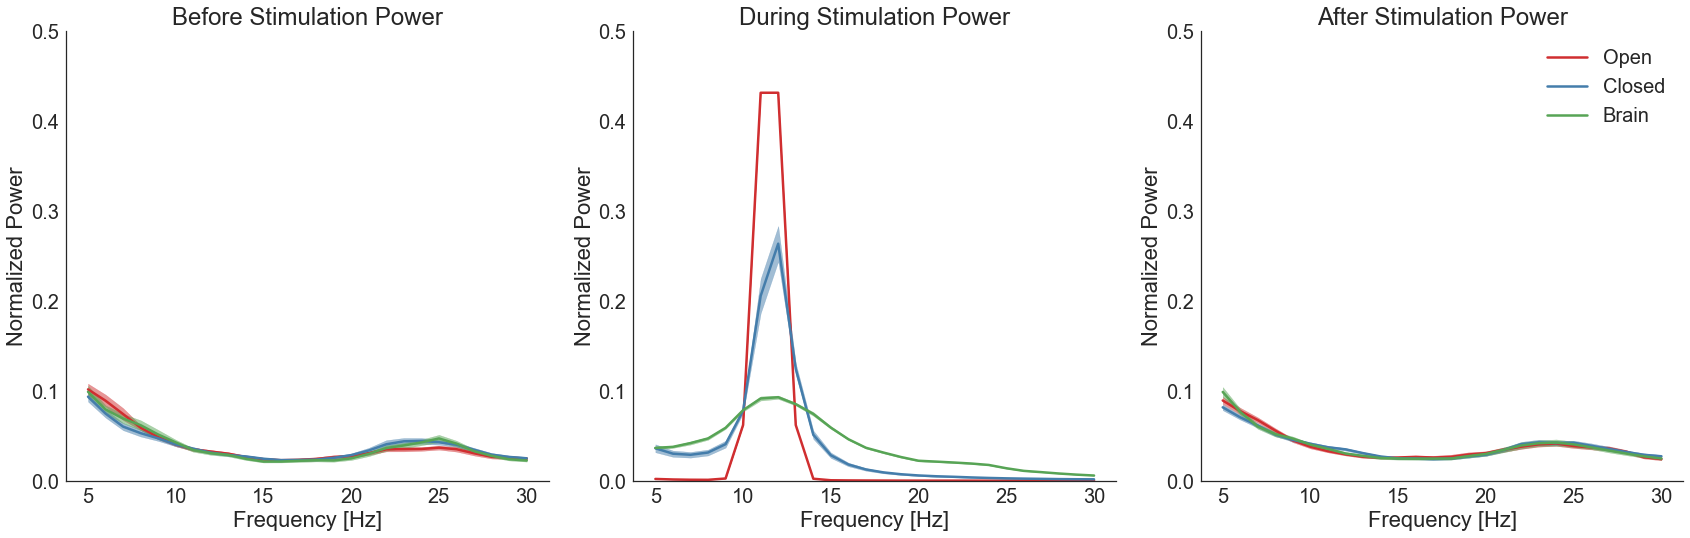

In [2]:
from plotting import plot_before_during_after_spectra

%matplotlib inline

fig = plot_before_during_after_spectra('main')

fig.savefig('../plots/main_experiment/main_before_during_after_spectra.png')
fig.show()

## Compare Post-Stim Power Between Conditions

### Bootstrap Test for Comparing to Baseline

#### Pre-Compute Bootstrap Indices

In [30]:
from statistics import pre_compute_bootstrap_indices

pre_compute_bootstrap_indices('main')

#### Compute the Bootstrap Distributions 

In [1]:
from statistics import compute_bootstrap_distribution

compute_bootstrap_distribution('main')

Computing Bootstrap Distribution for Condition: Open
Computing Bootstrap Distribution for Condition: Closed
Computing Bootstrap Distribution for Condition: Brain


#### Plot the Bootstrap TOI Distributions

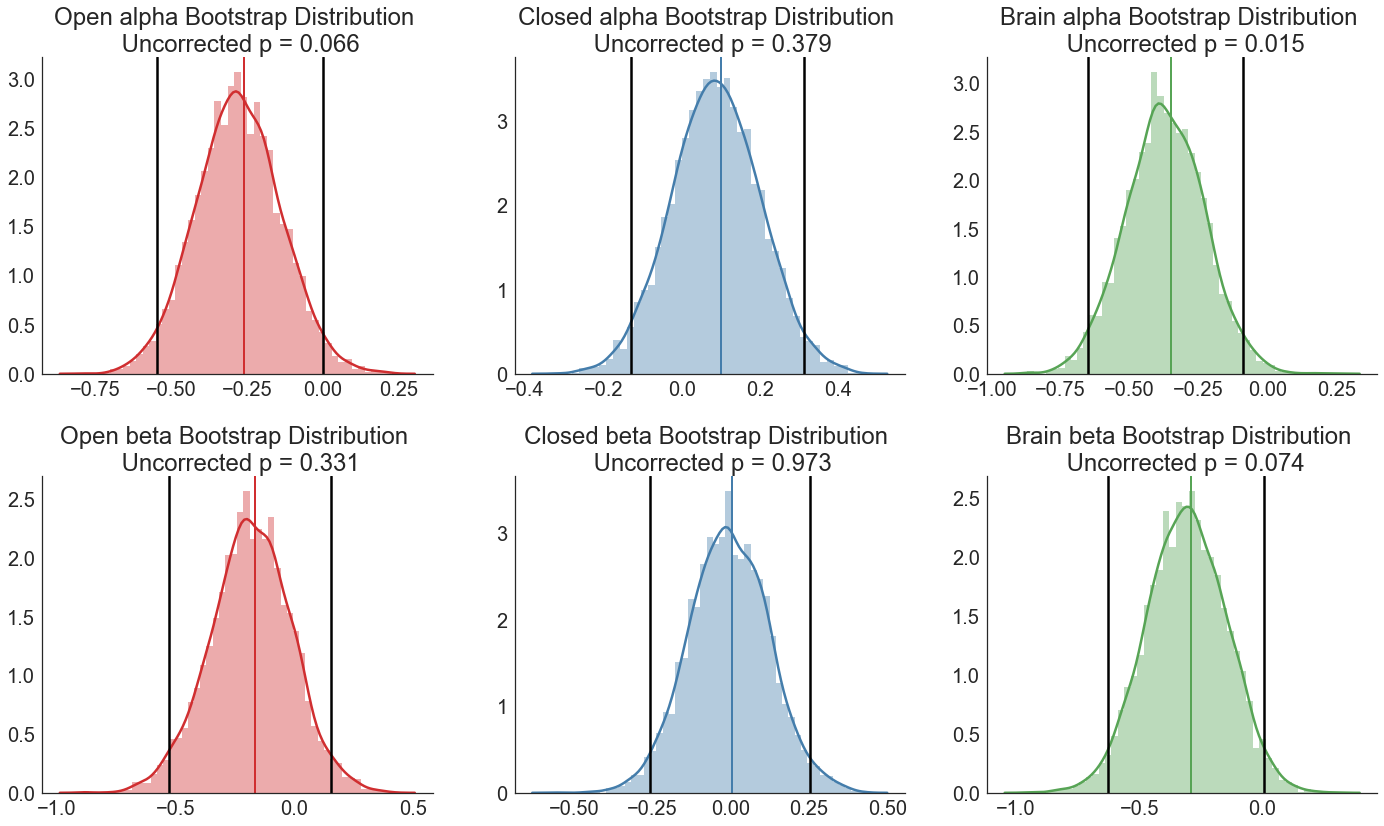

In [3]:
from plotting import plot_bootstrap_distributions

%matplotlib inline

fig = plot_bootstrap_distributions('main')

fig.savefig("../plots/main_experiment/main_condition_bootstrap_distributions.png")
fig.show()

### Permutation Test for Comparing Conditions

#### Pre-Compute Permutation Indices

In [5]:
from statistics import pre_compute_permutation_indices

pre_compute_permutation_indices('main')

#### Pre-Compute Sub-Sample Indices

In [6]:
from statistics import pre_compute_subsample_indices

pre_compute_subsample_indices('main')

#### Compute the Permutation Distributions

In [1]:
from statistics import compute_permutation_distributions

compute_permutation_distributions('main')

Computing Permutation Distribution for Condition Comparison: Open-Closed
Computing Permutation Distribution for Condition Comparison: Open-Brain
Computing Permutation Distribution for Condition Comparison: Brain-Closed


#### Plot the Permutation Distributions

/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/galileo/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


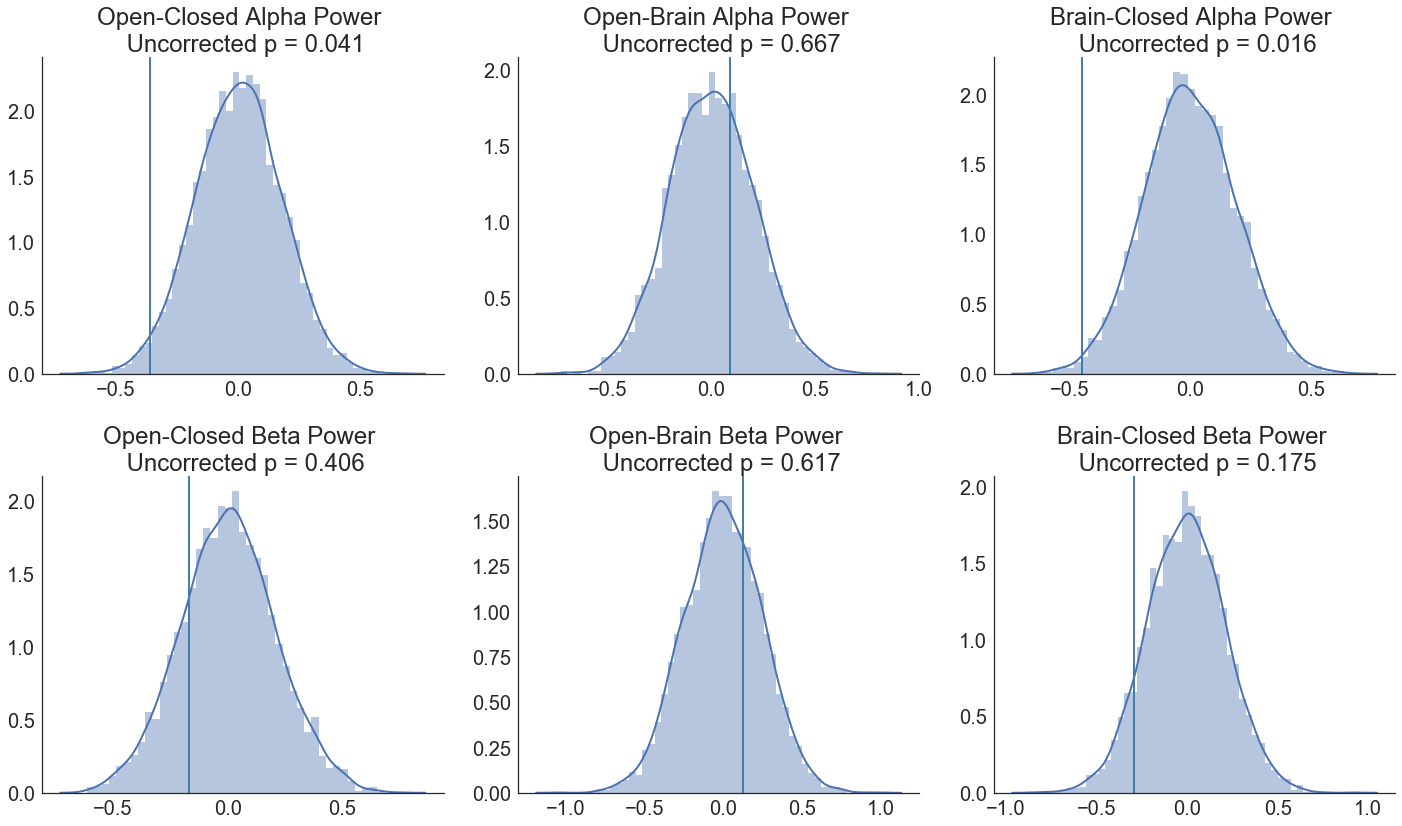

In [1]:
from plotting import plot_permutation_distributions

%matplotlib inline

fig = plot_permutation_distributions('main')
fig.savefig('../plots/main_experiment/main_condition_permutation_dists.png')
fig.show()

### Plot Condition TOI Comparison 

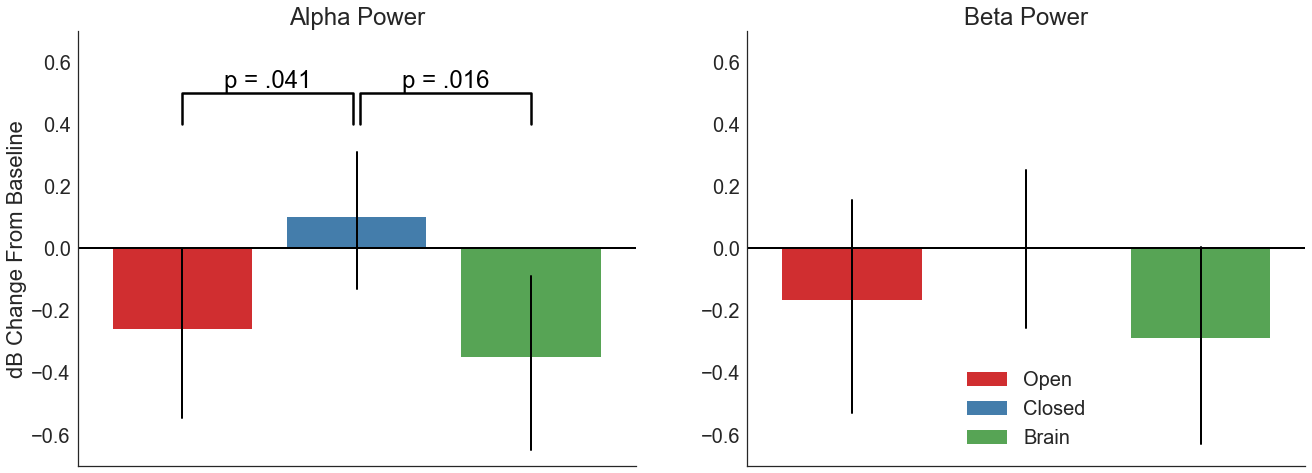

In [1]:
from plotting import plot_condition_toi_comparison

%matplotlib inline

fig = plot_condition_toi_comparison('main')
fig.savefig('../plots/main_experiment/main_condition_toi_comparison.png')

### Plot Condition Band Comparison

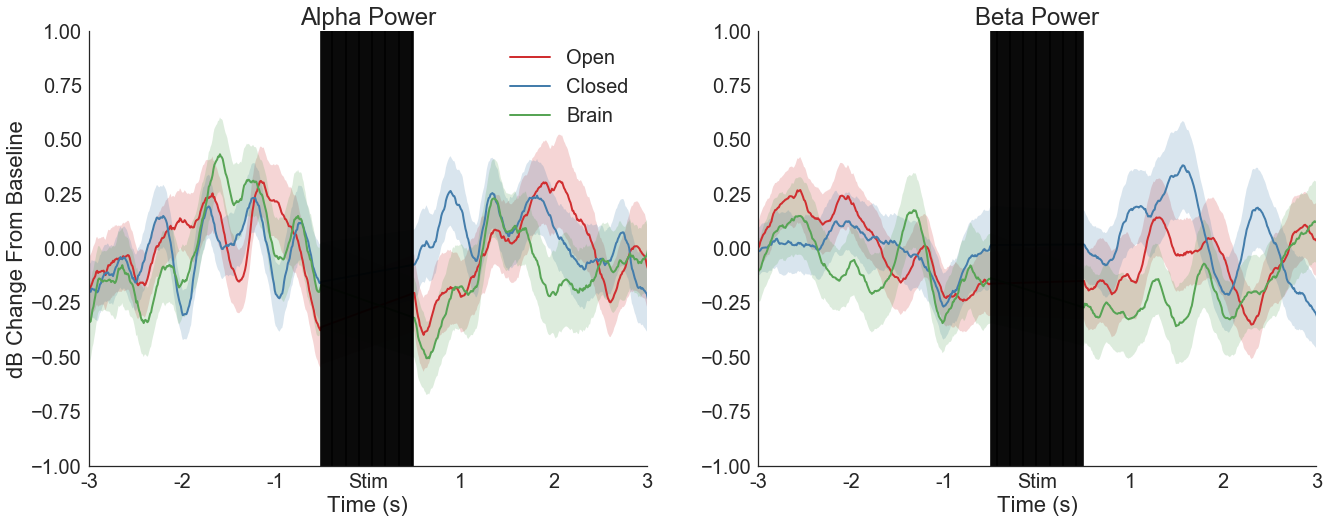

In [2]:
from plotting import plot_condition_band_comparison

%matplotlib inline

fig = plot_condition_band_comparison('main')
fig.savefig('../plots/main_experiment/main_condition_band_comparison.png')

## Compare Post-Stim Power Between Recording Arrays

### Permutation Test for Comparing Arrays

#### Compute the Permutation Distributions

In [1]:
from statistics import compute_array_permutation_distribution

compute_array_permutation_distribution('main')

Open
Closed
Brain
Done!


#### Plot the Permutation Distributions

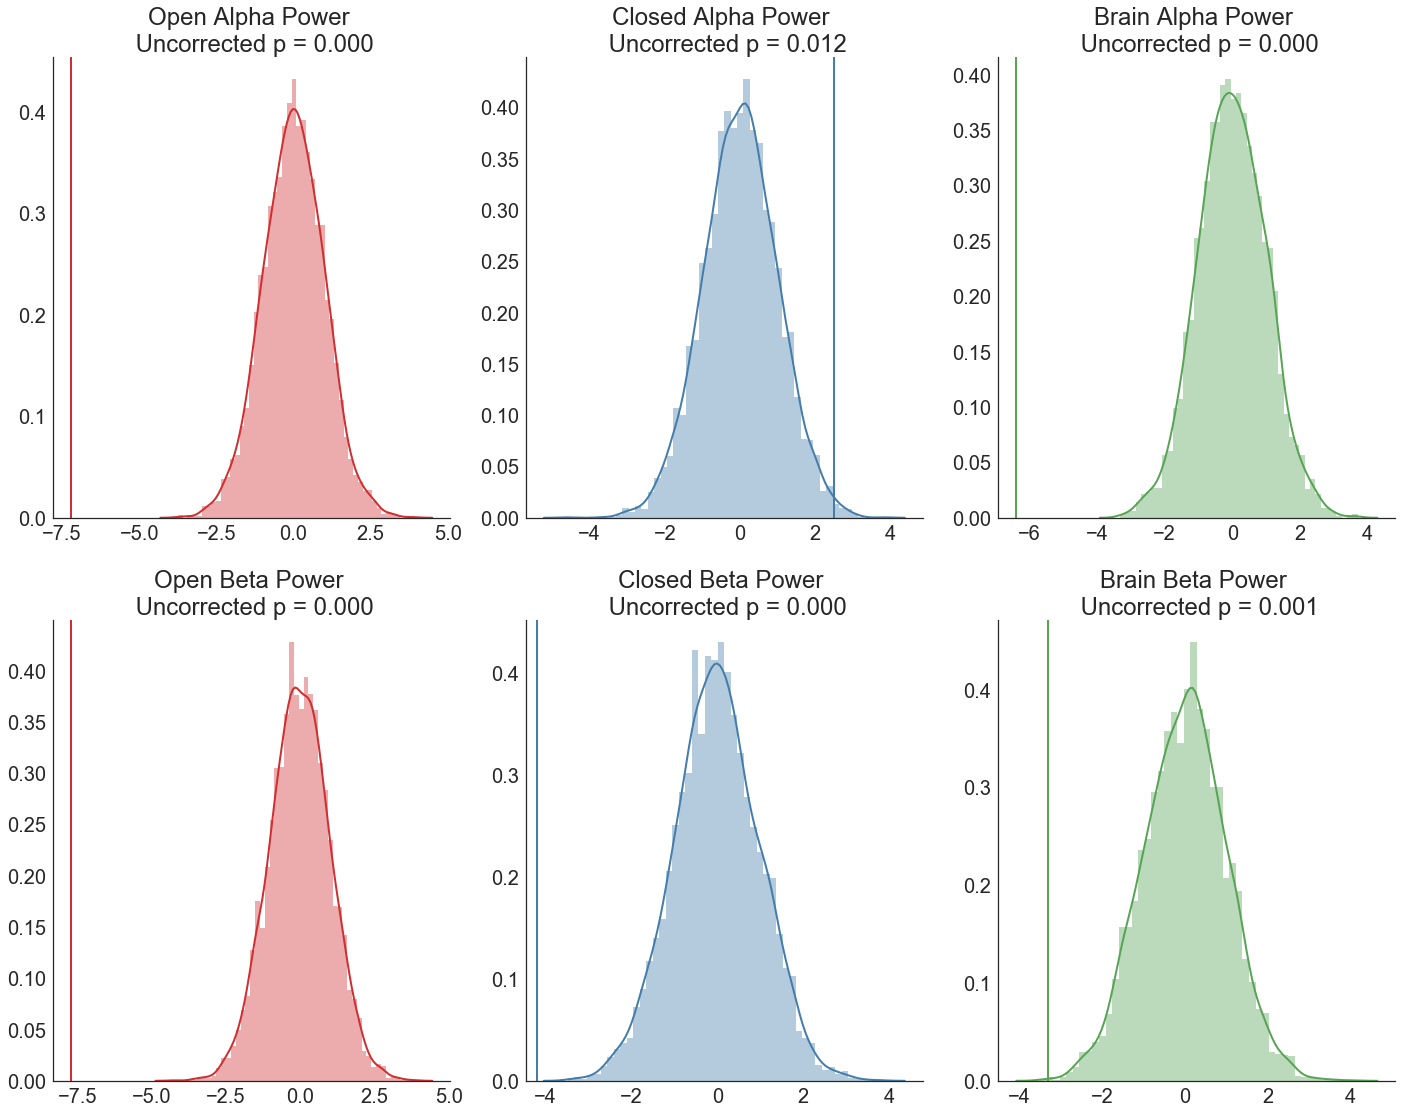

In [4]:
from plotting import plot_array_permutation_distributions

%matplotlib inline

fig = plot_array_permutation_distributions('main')

fig.savefig('../plots/main_experiment/array_permutation_dists.png')
fig.show()

### Plot Array TOI Comparison

/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/galileo/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


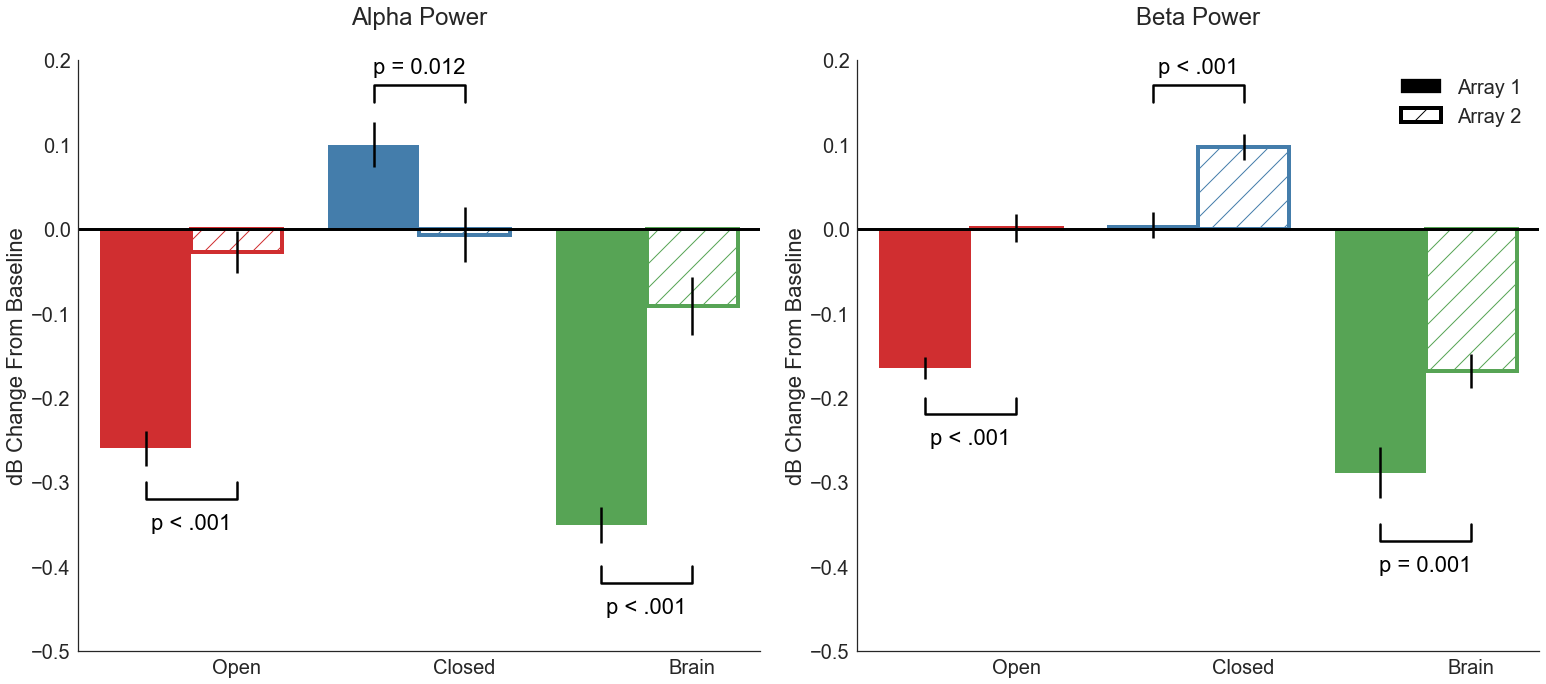

In [1]:
from plotting import plot_array_toi_comparison

%matplotlib inline

fig = plot_array_toi_comparison('main')

fig.savefig('../plots/main_experiment/main_array_toi_comparison.png')
fig.show()

### Plot Array Band Comparison

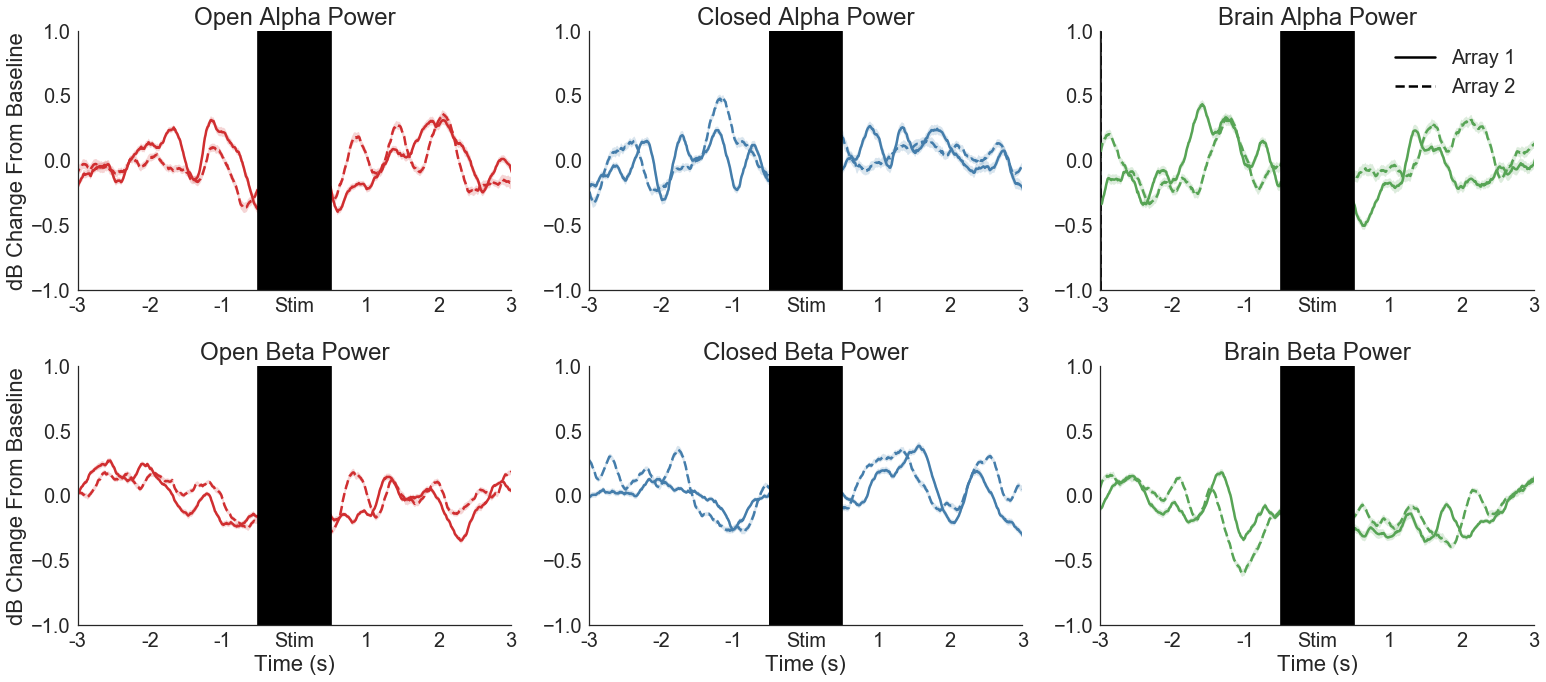

In [2]:
from plotting import plot_array_band_comparison

%matplotlib inline

fig = plot_array_band_comparison('main')

fig.savefig('../plots/main_experiment/main_array_band_comparison.png')
fig.show()

## Plot Early vs. Late Stimulation Spectra 

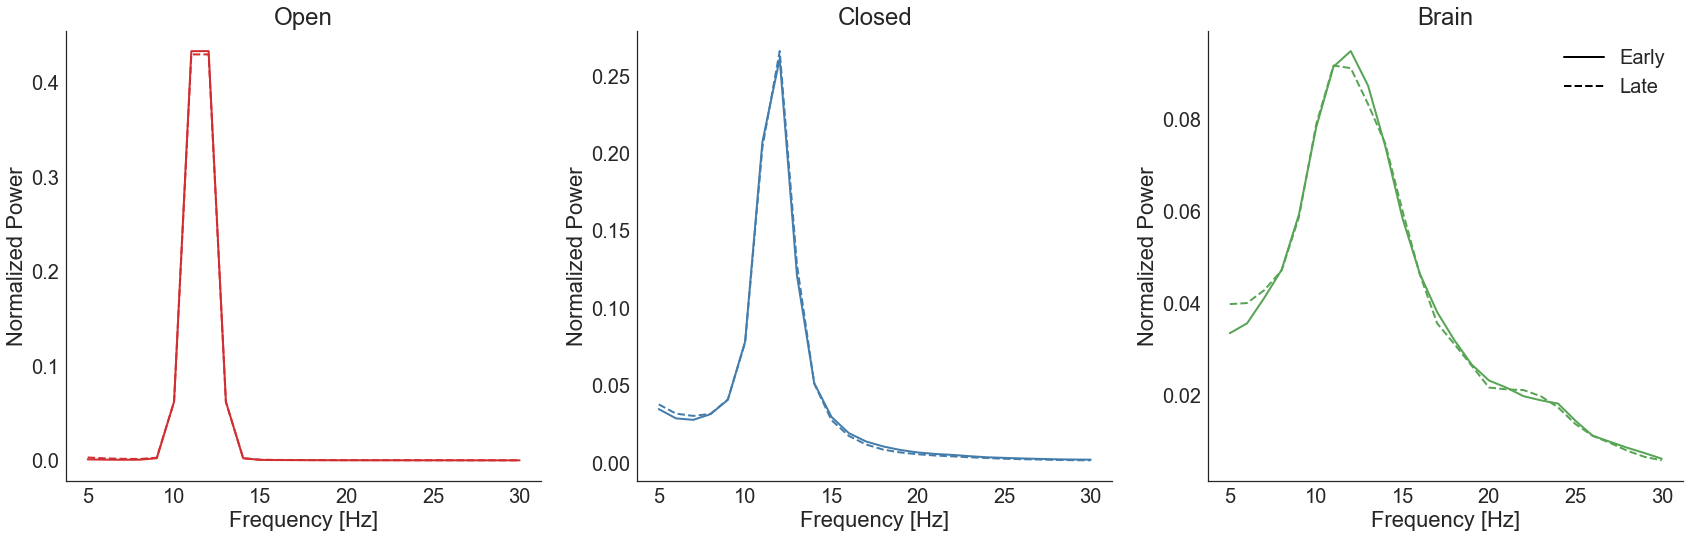

In [3]:
from plotting import plot_early_vs_late_stim_spectra

%matplotlib inline

fig = plot_early_vs_late_stim_spectra('main')

fig.savefig('../plots/main_experiment/early_vs_late_stim_spectra.png')
fig.show()

## Spectra of controlling electrode during stimulation

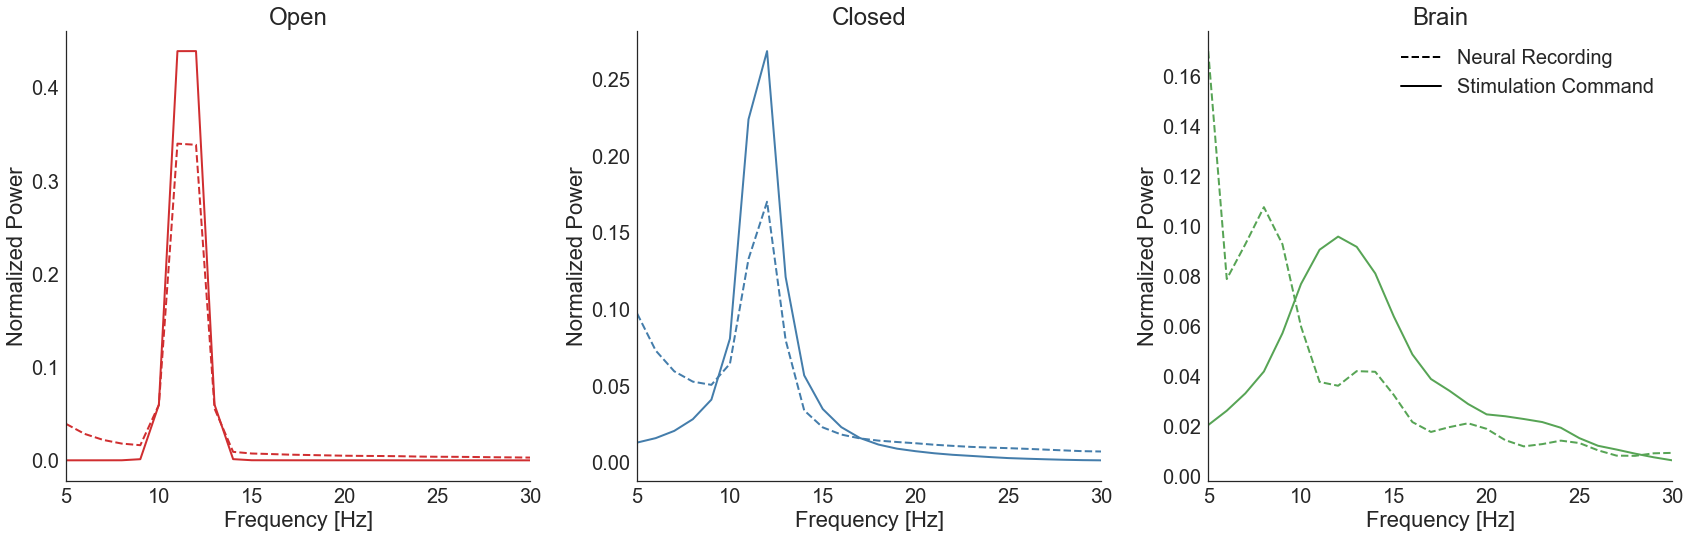

In [4]:
from plotting import plot_controlling_spectra

%matplotlib inline

fig = plot_controlling_spectra('main')

f = '../plots/main_experiment/main_controlling_stimulation_spectrum.png'
fig.savefig(f)
fig.show()

# Saline Experiment Analysis

Here we analyze the tfr data from the saline experiment. This control experiment was conducted in response to the reviews.

In [2]:
import os

if not os.path.exists('../plots/saline_experiment'):
    os.makedirs('../plots/saline_experiment')
if not os.path.exists('../stats/saline_experiment'):
    os.makedirs('../stats/saline_experiment')

## Plot Before, During, and After Spectra

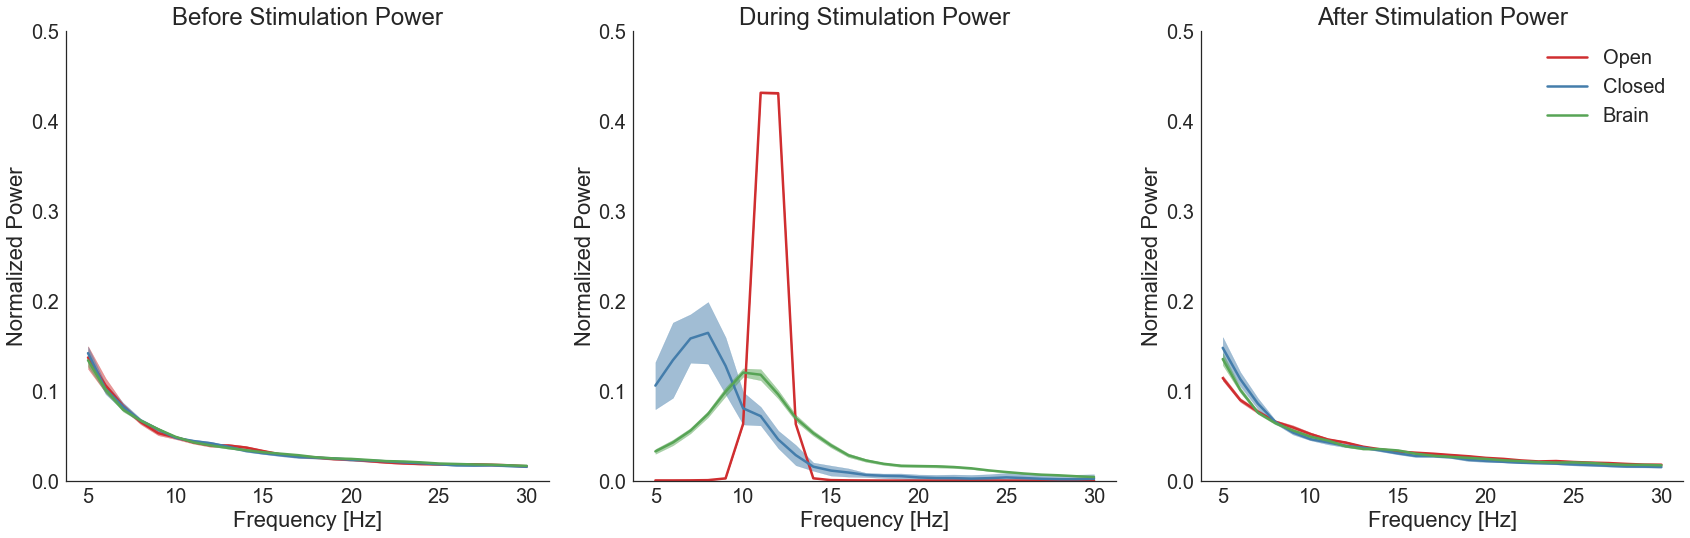

In [3]:
from plotting import plot_before_during_after_spectra

fig = plot_before_during_after_spectra('saline')

fig.savefig('../plots/saline_experiment/saline_before_during_after_spectrum.png')
fig.show()

## Compare Post-Stim Power Between Conditions

### Bootstrap Test for Comparing to Baseline

#### Pre-Compute Bootstrap Indices

In [19]:
from statistics import pre_compute_bootstrap_indices

pre_compute_bootstrap_indices('saline')

#### Compute the Bootstrap Distributions

In [20]:
from statistics import compute_bootstrap_distribution

compute_bootstrap_distribution('saline')

Computing Bootstrap Distribution for Condition: Open
Computing Bootstrap Distribution for Condition: Closed
Computing Bootstrap Distribution for Condition: Brain


#### Plot the Bootstrap TOI Distributions

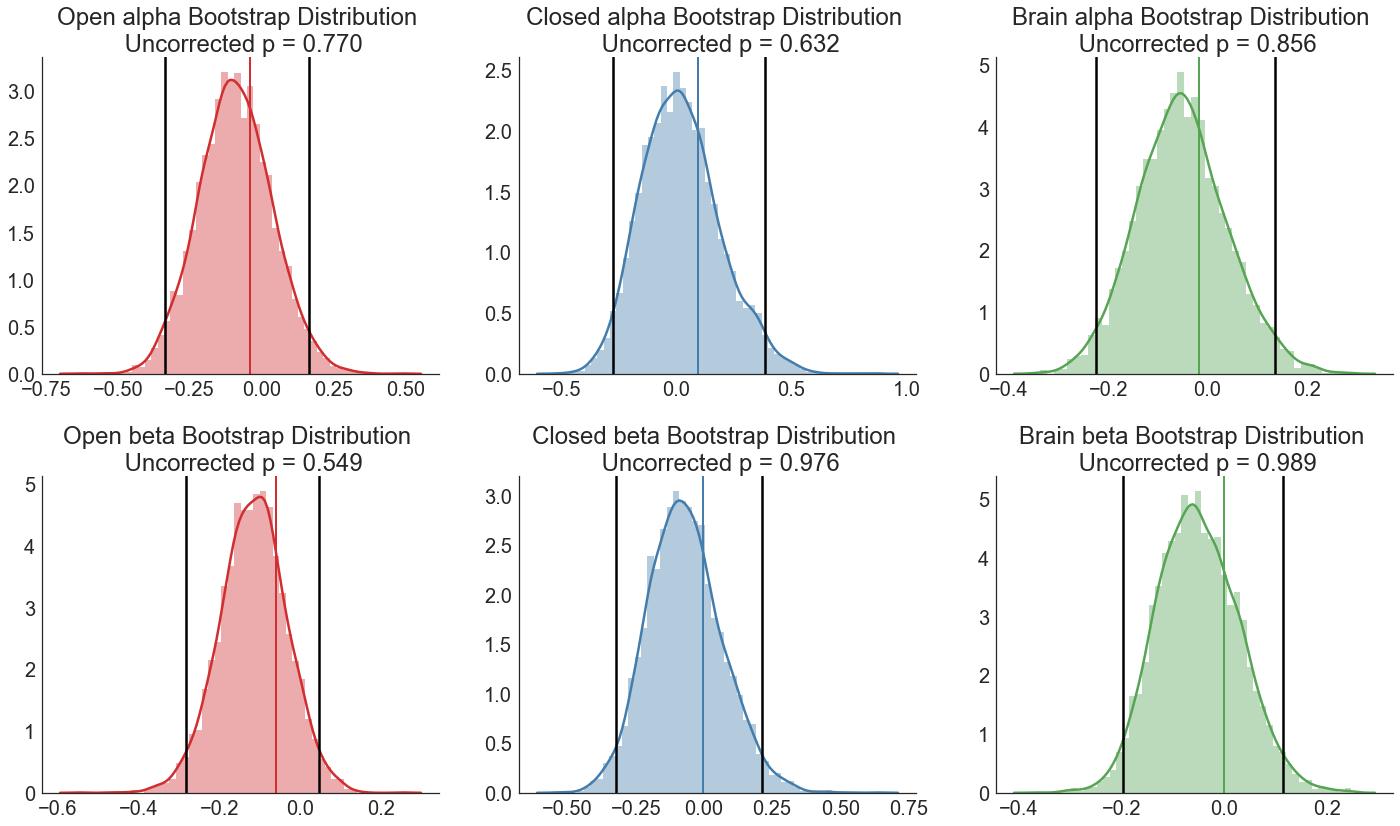

In [4]:
from plotting import plot_bootstrap_distributions

%matplotlib inline

fig = plot_bootstrap_distributions('saline')

f = '../plots/saline_experiment/saline_condition_bootstrap_distributions.png'
fig.savefig(f)
fig.show()

### Permutation Test for Comparing Conditions

#### Pre-Compute Permutation Indices 

In [22]:
from statistics import pre_compute_permutation_indices

pre_compute_permutation_indices('saline')

#### Pre-Compute Sub-Sample Indices

In [23]:
from statistics import pre_compute_subsample_indices

pre_compute_subsample_indices('saline')

#### Compute the Permutation Distributions

In [24]:
from statistics import compute_permutation_distributions

compute_permutation_distributions('saline')

Computing Permutation Distribution for Condition Comparison: Open-Closed
Computing Permutation Distribution for Condition Comparison: Open-Brain
Computing Permutation Distribution for Condition Comparison: Brain-Closed


#### Plot Permutation Distributions 

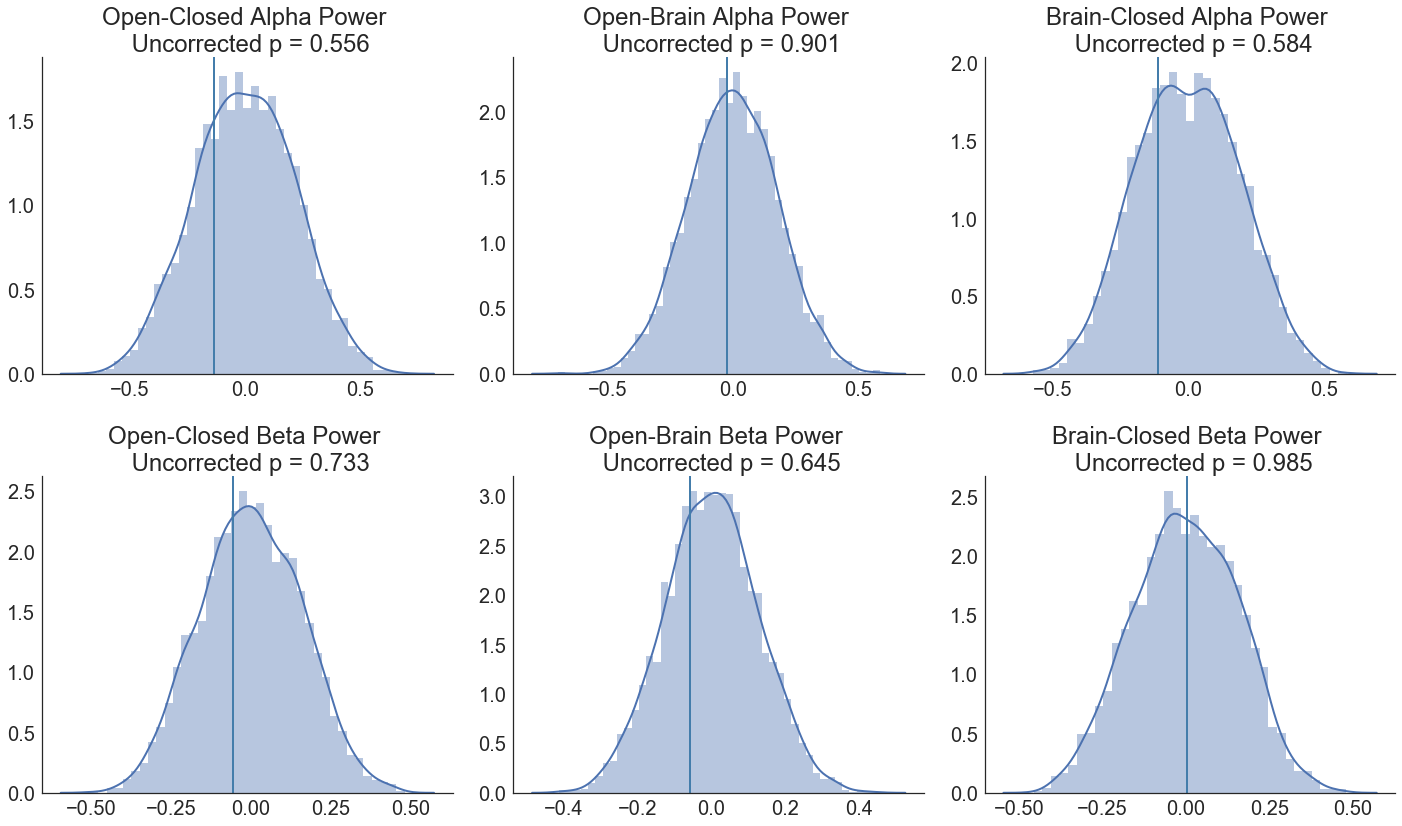

In [5]:
from plotting import plot_permutation_distributions

%matplotlib inline

fig = plot_permutation_distributions('saline')
fig.savefig('../plots/saline_experiment/saline_condition_permutation_dists.png')
fig.show()

### Plot Condition TOI Comparison 

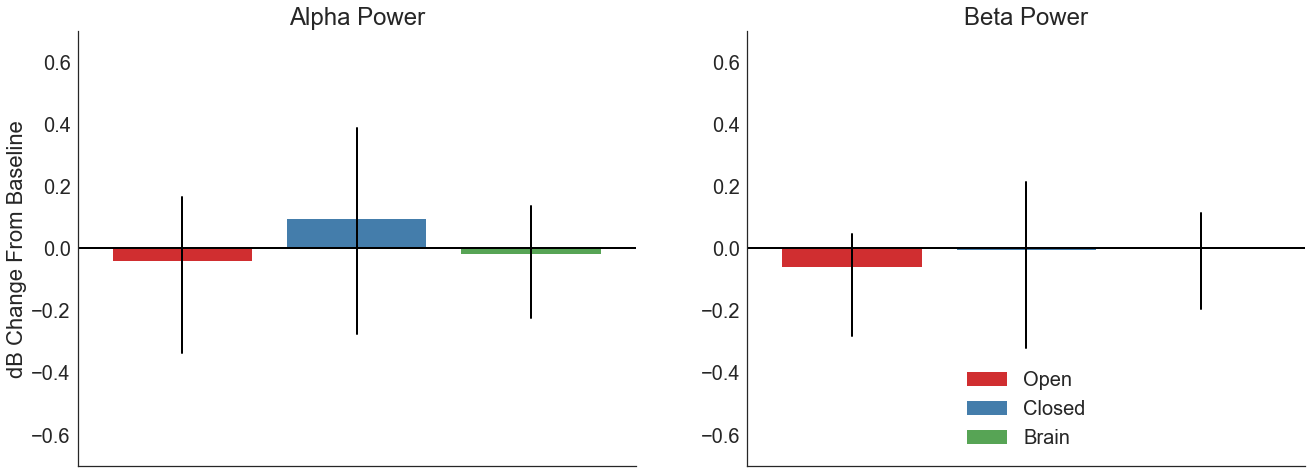

In [6]:
from plotting import plot_condition_toi_comparison

%matplotlib inline

fig = plot_condition_toi_comparison('saline')
fig.savefig('../plots/saline_experiment/saline_condition_toi_comparison.png')

### Plot Condition Band Comparison 

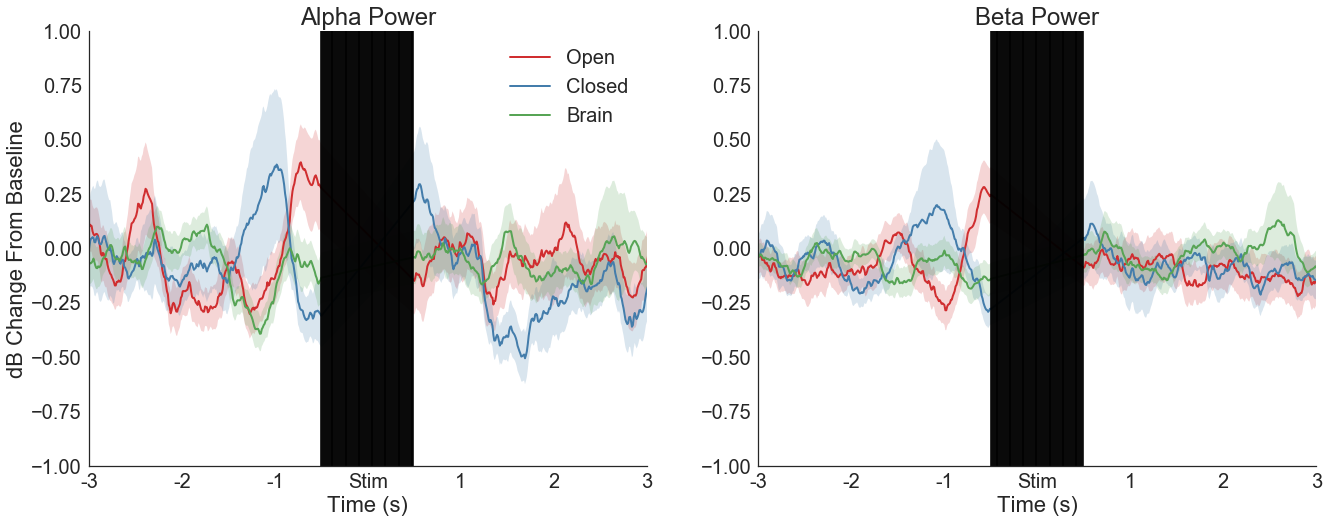

In [7]:
from plotting import plot_condition_band_comparison

%matplotlib inline

fig = plot_condition_band_comparison('saline')

fig.savefig("../plots/saline_experiment/saline_condition_band_comparison.png")
fig.show()